In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [11]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [12]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [13]:
# features = {}
# directory = os.path.join(BASE_DIR, 'Images')

# for img_name in tqdm(os.listdir(directory)):
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     image = preprocess_input(image)
#     feature = model.predict(image, verbose=0)
#     image_id = img_name.split('.')[0]
#     features[image_id] = feature

In [14]:
# from IPython.display import FileLink


# pickle.dump(features,open(os.path.join('/kaggle/input/hello-world',"features.pkl"),'wb'))
# FileLink(r'features.pkl')


In [15]:
features = {}
with open(os.path.join('.',"features.pkl"),'rb') as f:
    features = pickle.load(f)

In [16]:
with open(os.path.join(".",'captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

In [17]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id,caption = tokens[0],tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [18]:
len(mapping)

8091

In [19]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]','')
            caption = caption.replace('\s+',' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [20]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:
clean(mapping)

In [22]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [23]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [24]:
len(all_captions)

40455

In [6]:
tokenizer = Tokenizer()
with open('tokenizer.pkl','rb') as f:
    tokenizer = pickle.load(f)
# tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [4]:
max_length = 35

In [15]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1, X2,y = list(),list(),list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i],seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1,X2,y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y = list(),list(),list()
                n = 0

In [7]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[inputs1,inputs2],outputs = outputs)
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
from IPython.display import FileLink
epochs = 25
batch_size = 64
steps = len(train)//batch_size

for i in range(epochs):
    generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    if i%5==0:
        model.save(WORKING_DIR+f'/best_model{i}.h5')
        FileLink(f'best_model{i}.h5')
model.save(WORKING_DIR+f'/best_model60.h5')
FileLink(r'best_model60.h5')

113/113 [==============================] - 63s 552ms/step - loss: 2.1525


/kaggle/working/best_model60.h5

In [8]:
model.load_weights('best_model25.h5')

In [21]:
model.save(WORKING_DIR+f'/best_model60.h5')
FileLink(r'best_model60.h5')

/kaggle/working/best_model60.h5

In [9]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [10]:
def predict_caption(model,image,tokenizer,max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],max_length)
        
        yhat = model.predict([image, seq],verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    return in_text

In [24]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(),list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model,features[key],tokenizer,max_length)
    y_pred = y_pred.split()
    actual_captions = [caption.split() for caption in captions]
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1 %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2 %f" % corpus_bleu(actual,predicted,weights=(0.5,0,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # image_id = image_name.split('.')[0]
    # image_path = os.path.join(BASE_DIR,"Images",image_name)
    image = Image.open(image_name)
    captions = mapping[image_id]
    print('---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model,features[image_id],tokenizer,max_length)
    print("--------------------")
    print(y_pred)
    plt.imshow(image)

---------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
--------------------
startseq man is climbing up steep rock wall endseq


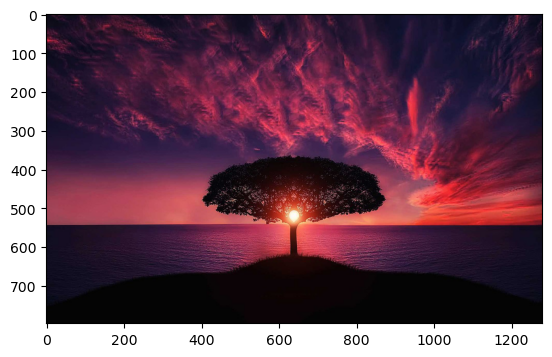

In [23]:
image_name = "tree-736885_1280.jpg"
generate_caption(image_name)

In [11]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs,outputs=vgg_model.layers[-2].output)

In [12]:
image_path = "./photo.jpg"
image = load_img(image_path,target_size=(224,224))
image = img_to_array(image)
image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image,verbose=0)
predict_caption(model,feature,tokenizer,max_length)

'startseq children playing with medieval children endseq'